In [1]:
import os
import torch
import torch.nn.functional as F
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Amazon
print("PyTorch Version: ", torch.__version__)
print("PyG Version: ", torch_geometric.__version__)

PyTorch Version:  1.9.0+cu111
PyG Version:  2.0.2


## 加载数据集

In [2]:
dataset_dir = "./data"
dataset_name = "Photo"
dataset = Amazon(dataset_dir, dataset_name, transform=T.NormalizeFeatures())    # 若不存在数据集,则自动下载,并对数据进行normalize
data = dataset[0]

# 查看数据集的基本信息
print("data:", data)
# data: Data(x=[7650, 745], edge_index=[2, 238162], y=[7650])
# edge_index=[src, des], y=[每个节点对应的label]
print("节点数: {}, 边数: {}, 特征维度: {}, 分类类别数: {}".format(
    data.num_nodes, data.num_edges, data.num_node_features, dataset.num_classes
))

data: Data(x=[7650, 745], edge_index=[2, 238162], y=[7650])
节点数: 7650, 边数: 238162, 特征维度: 745, 分类类别数: 8


Photo_mask.pth文件划分信息如下：
- 训练、验证、测试数据集划分比例为`1:1:8`
- 总共20种划分, 因此最终需要给出20个划分中测试集的平均分类准确率

In [3]:

# print(data.train_mask, data.val_mask, data.test_mask)    # 若直接访问会产生KeyError
train_mask, val_mask, test_mask = torch.load('./mask/Photo_mask.pth')
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
print("训练集划分: {}, 训练样本数: {}".format(train_mask.size(), torch.sum(train_mask[0])))
print("验证集划分: {}, 验证样本数: {}".format(val_mask.size(), torch.sum(val_mask[0])))
print("测试集划分: {}, 测试样本数: {}".format(test_mask.size(), torch.sum(test_mask[0])))
# 即，训练集、验证集、测试集是下标0到19的二维数组，每个下标对应一个划分
# 每个划分长度7650，当中True表集合中的点
# mask，掩码，只是表选中哪个节点做训练/验证/测试集


训练集划分: torch.Size([20, 7650]), 训练样本数: 765
验证集划分: torch.Size([20, 7650]), 验证样本数: 765
测试集划分: torch.Size([20, 7650]), 测试样本数: 6120


In [4]:
print(train_mask[19])
num = 0
for i in train_mask[0]:
    if i :
        num = num+1
print("train_mask[0]:", num)

tensor([ True, False, False,  ..., False, False, False])
train_mask[0]: 765


## 模型搭建

In [5]:
from torch_geometric.nn import GCNConv
# 搭建二层GCN
class GCN_NET(torch.nn.Module):
    def __init__(self, features, hidden, classes):
        super(GCN_NET, self).__init__()
        # 第一层卷积层
        self.conv1 = GCNConv(in_channels=features, out_channels=hidden, add_self_loops=True, normalize=True, bias=False)
        # 第二层卷积层
        self.conv2 = GCNConv(hidden, classes, add_self_loops=True, normalize=True, bias=False)
    def forward(self, data):
        # 加载节点及邻接关系
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

## 训练测试代码

In [128]:
import torch.nn as nn
import numpy as np

Epoch = 800

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
loss_fn = nn.CrossEntropyLoss()
model = [GCN_NET(data.num_node_features, 16, dataset.num_classes) for _ in range(20)]   # 推导式定义20个模型
for i in range(20):
    model[i] = model[i].to(device)
optimizer = [torch.optim.Adam(model[i].parameters(), lr=0.1, weight_decay=4e-5) for i in range(20)]

# train 定义每轮训练
def train(i, mask):
    model[i].train()
    optimizer[i].zero_grad()   # 梯度清零; 第i个模型搭配第i个优化器
    out = model[i](data)
    loss = loss_fn(out[mask], data.y[mask]) # 计算交叉熵损失
    loss.backward()
    optimizer[i].step()

# test 定义测试代码
def test(i, mask):
    model[i].eval()
    out = model[i](data)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    loss = loss_fn(out[mask], data.y[mask]) # 计算交叉熵损失
    return acc, loss

def main():
    # 记录数据用于画图
    train_cur_loss = np.zeros(Epoch, dtype=float)
    val_cur_loss = np.zeros(Epoch, dtype=float)
    test_cur_loss = np.zeros(Epoch, dtype=float)

    train_cur_acc = np.zeros(Epoch, dtype=float)
    val_cur_acc = np.zeros(Epoch, dtype=float)
    test_cur_acc = np.zeros(Epoch, dtype=float)
    sum_test_acc = 0
    
    for i in range(0, 20):  # 选择模型进行训练
        max_val_acc, max_test_acc = 0, 0
        for epoch in range(0, Epoch):
            train(i, train_mask[i])
            train_acc, train_loss = test(i, train_mask[i])
            val_acc, val_loss = test(i, val_mask[i])
            test_acc, test_loss = test(i, test_mask[i])
            if epoch < 10:
                print(f'partition {i} epoch {epoch:03d}: train_acc {train_acc:.4f}, train_loss {train_loss:.4f},    val_acc {val_acc:.4f}, val_loss {val_loss:.4f},    test_acc {test_acc:.4f}, test_loss {test_loss:.4f}')
            # 赋值
            train_cur_loss[epoch] = train_cur_loss[epoch] + train_loss
            train_cur_acc[epoch] = train_cur_acc[epoch] + train_acc
            val_cur_loss[epoch] = val_cur_loss[epoch] + val_loss
            val_cur_acc[epoch] = val_cur_acc[epoch] + val_acc
            test_cur_loss[epoch] = test_cur_loss[epoch] + test_loss
            test_cur_acc[epoch] = test_cur_acc[epoch] + test_acc
            # 求最优验证集acc对应的val_acc
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                max_test_acc = test_acc
        sum_test_acc = sum_test_acc + max_test_acc
        print(f'划分 {i} 上的最优 val acc 对应的 test acc 为 {max_test_acc:.4f}')

    print()
    print(f'根据最优验证集平均准确率，对每个划分得到的最优test_acc进行平均得到: {sum_test_acc/20: .4f}')

    return train_cur_loss, val_cur_loss, test_cur_loss, train_cur_acc, val_cur_acc, test_cur_acc

train_cur_loss, val_cur_loss, test_cur_loss, train_cur_acc, val_cur_acc, test_cur_acc = main()

partition 0 epoch 000: train_acc 0.2314, train_loss 2.0451,    val_acc 0.2431, val_loss 2.0452,    test_acc 0.2578, test_loss 2.0414
partition 0 epoch 001: train_acc 0.2314, train_loss 1.9939,    val_acc 0.2431, val_loss 1.9951,    test_acc 0.2578, test_loss 1.9875
partition 0 epoch 002: train_acc 0.2314, train_loss 1.9418,    val_acc 0.2431, val_loss 1.9457,    test_acc 0.2578, test_loss 1.9366
partition 0 epoch 003: train_acc 0.2314, train_loss 1.9218,    val_acc 0.2431, val_loss 1.9314,    test_acc 0.2578, test_loss 1.9228
partition 0 epoch 004: train_acc 0.4301, train_loss 1.9070,    val_acc 0.4458, val_loss 1.9273,    test_acc 0.4541, test_loss 1.9197
partition 0 epoch 005: train_acc 0.3542, train_loss 1.8834,    val_acc 0.3516, val_loss 1.9150,    test_acc 0.3580, test_loss 1.9071
partition 0 epoch 006: train_acc 0.3033, train_loss 1.8574,    val_acc 0.3072, val_loss 1.8966,    test_acc 0.3039, test_loss 1.8873
partition 0 epoch 007: train_acc 0.4039, train_loss 1.8283,    val_ac

## 损失、准确率可视化曲线绘制代码
建议包括训练集损失、验证集损失、测试集损失及准确率的Epoch曲线图

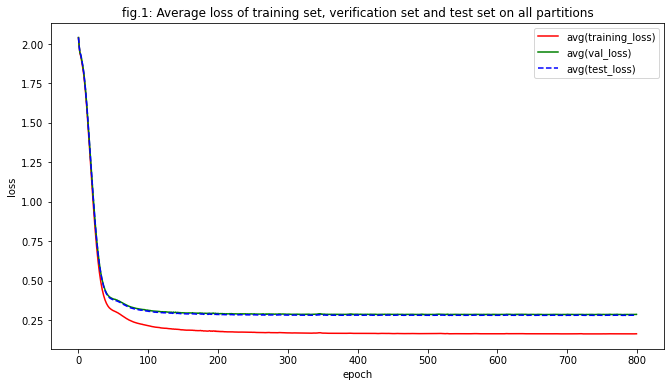

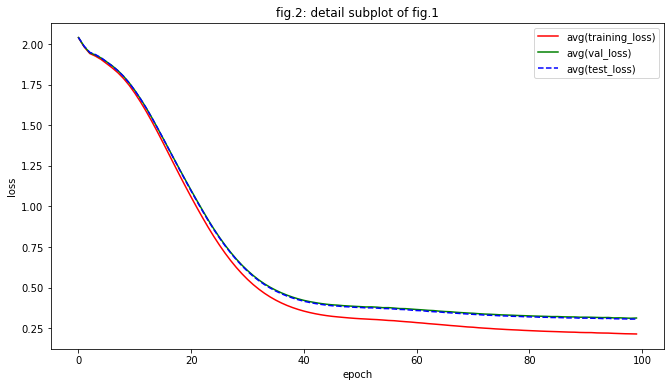

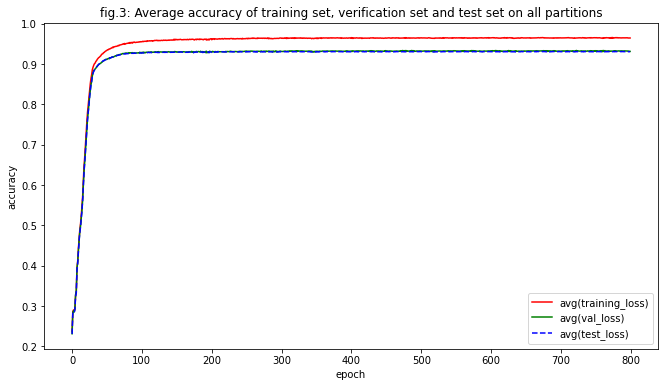

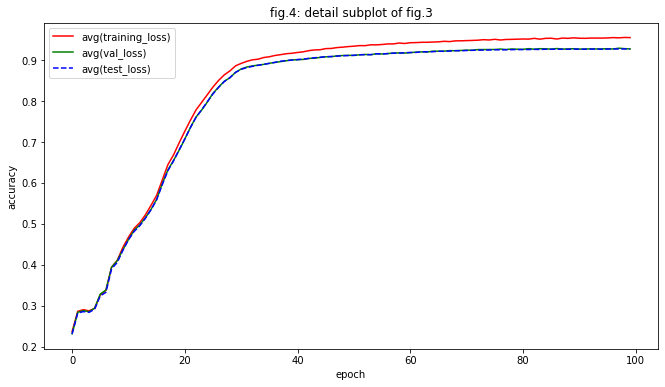

In [138]:
import matplotlib.pyplot as plt

def plot_cur():
    # plot 1: loss fig
    x = np.arange(0, Epoch, 1)
    plt.figure(figsize=(11, 6))
    plt.plot(x, train_cur_loss/20, color='red', label='avg(training_loss)')
    plt.plot(x, val_cur_loss/20, color='green', label='avg(val_loss)')
    plt.plot(x, test_cur_loss/20, color='blue', linestyle='--', label='avg(test_loss)')

    plt.title('fig.1: Average loss of training set, verification set and test set on all partitions')
    plt.xlabel('epoch')
    plt.ylabel('loss')  
    plt.legend()
    plt.show()

    
    # plot 2: loss图的子图（只取坐标[0, 100]的范围）
    x1 = np.arange(0, 100, 1)
    plt.figure(figsize=(11, 6))
    plt.plot(x1, train_cur_loss[:100]/20, color='red', label='avg(training_loss)')
    plt.plot(x1, val_cur_loss[:100]/20, color='green', label='avg(val_loss)')
    plt.plot(x1, test_cur_loss[:100]/20, color='blue', linestyle='--', label='avg(test_loss)')
    plt.title('fig.2: detail subplot of fig.1')
    plt.xlabel('epoch')
    plt.ylabel('loss')  
    plt.legend()
    plt.show()


    # plot 3: acc fig
    plt.figure(figsize=(11, 6))
    plt.plot(x, train_cur_acc/20, color='red', label='avg(training_loss)')
    plt.plot(x, val_cur_acc/20, color='green', label='avg(val_loss)')
    plt.plot(x, test_cur_acc/20, color='blue', linestyle='--', label='avg(test_loss)')
    plt.title('fig.3: Average accuracy of training set, verification set and test set on all partitions')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    # plot 4: acc图的子图（只取坐标[0, 100]的范围）
    x1 = np.arange(0, 100, 1)
    plt.figure(figsize=(11, 6))
    plt.plot(x1, train_cur_acc[:100]/20, color='red', label='avg(training_loss)')
    plt.plot(x1, val_cur_acc[:100]/20, color='green', label='avg(val_loss)')
    plt.plot(x1, test_cur_acc[:100]/20, color='blue', linestyle='--', label='avg(test_loss)')
    plt.title('fig.4: detail subplot of fig.3')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
plot_cur()
